In [ ]:
from tensorflow.keras import Input, layers, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, Softmax, Embedding, Concatenate, Permute, Reshape, Activation
from tensorflow.keras.optimizers import Adam
import numpy as np
from keras.utils import np_utils
from tensorflow.keras.datasets import mnist
from keras.utils.np_utils import to_categorical
from tensorflow.keras import backend as K
import tensorflow as tf
from keras.utils.generic_utils import get_custom_objects
(X, Y_train), (X_test, Y_test) = mnist.load_data()
Y_train = to_categorical(Y_train)
X_train = X.reshape(X.shape + (1,))
X_test = X_test.reshape(X_test.shape + (1,))
Y_test = to_categorical(Y_test)
split = float(1./6.)
#tf.config.run_functions_eagerly(True)

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
input = Input((X_train.shape[1], X_train.shape[2], 1))
conv2d1 = Conv2D(32, kernel_size = (3, 3), activation = "relu", padding = "same")(input)
maxpool1 = MaxPool2D((2, 2))(conv2d1)
conv2d2 = Conv2D(64, kernel_size = (3, 3), activation = "relu", padding = "same")(maxpool1)
maxpool2 = MaxPool2D((2, 2))(conv2d2)
flatten = Flatten()(maxpool2)
dropout = Dropout(0.5)(flatten)
#dense1 = Dense(128, activation = "relu")(dropout)
output = Dense(10, activation = "softmax")(dropout)
model_cnn = Model(input, output)
model_cnn.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
num_epochs = 15
training = model_cnn.fit(X_train, Y_train, batch_size = 128, epochs = num_epochs, validation_split = split, verbose = 1)

Epoch 1/15
391/391 [==============================] - 14s 11ms/step - loss: 0.7879 - accuracy: 0.8803 - val_loss: 0.0744 - val_accuracy: 0.9782
Epoch 2/15
391/391 [==============================] - 4s 9ms/step - loss: 0.1342 - accuracy: 0.9582 - val_loss: 0.0538 - val_accuracy: 0.9843
Epoch 3/15
391/391 [==============================] - 4s 9ms/step - loss: 0.0972 - accuracy: 0.9691 - val_loss: 0.0453 - val_accuracy: 0.9862
Epoch 4/15
391/391 [==============================] - 4s 9ms/step - loss: 0.0802 - accuracy: 0.9752 - val_loss: 0.0483 - val_accuracy: 0.9880
Epoch 5/15
391/391 [==============================] - 4s 10ms/step - loss: 0.0749 - accuracy: 0.9763 - val_loss: 0.0451 - val_accuracy: 0.9870
Epoch 6/15
391/391 [==============================] - 4s 9ms/step - loss: 0.0659 - accuracy: 0.9782 - val_loss: 0.0431 - val_accuracy: 0.9879
Epoch 7/15
391/391 [==============================] - 4s 9ms/step - loss: 0.0653 - accuracy: 0.9793 - val_loss: 0.0433 - val_accuracy: 0.9886
Epo

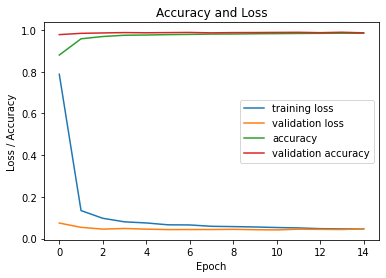

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(np.arange(0, num_epochs), training.history['loss'], label='training loss')
plt.plot(np.arange(0, num_epochs), training.history['val_loss'], label='validation loss')
plt.plot(np.arange(0, num_epochs), training.history['accuracy'], label='accuracy')
plt.plot(np.arange(0, num_epochs), training.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()

In [ ]:
model_cnn.evaluate(X_test, Y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0420 - accuracy: 0.9880


[0.04204168543219566, 0.9879999756813049]

In [ ]:
n_vocabs = 256
class DotProduct(layers.Layer):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
  def call(self, t_queries, t_keys, t_values):
    softmax_layer = Softmax(axis = -1)
    softmax_output = softmax_layer(tf.matmul(t_queries, tf.transpose(t_keys, [0, 2, 1]))/np.sqrt(t_queries.shape[2]))
    return tf.matmul(softmax_output, t_values)

In [ ]:
class Attention(layers.Layer):
  def __init__(self, qk_hidden,  v_hidden, **kwargs):
    super().__init__(**kwargs)
    self.dense_queries = Dense(qk_hidden, activation = "relu")
    self.dense_keys = Dense(qk_hidden, activation = "relu")
    self.dense_values = Dense(v_hidden, activation = "relu")
    self.dot_product = DotProduct()
    self.flatten = Flatten()
  def call(self, pixels_embedding, positions_embedding):
    embedding = pixels_embedding + positions_embedding
    t_queries = self.dense_queries(embedding)
    t_keys = self.dense_keys(embedding)
    t_values = self.dense_values(embedding)
    values_probability = self.dot_product(t_queries, t_keys, t_values)
    return values_probability
class MultiAttention(layers.Layer):
  def __init__(self, qk_hiddens, v_hidden, **kwargs):
    super().__init__(**kwargs)
    self.qk_hiddens = qk_hiddens
    self.v_hidden = v_hidden
    self.list_attention = [Attention(self.qk_hiddens[i], self.v_hidden) for i in range(len(self.qk_hiddens))]
    self.concatenate = Concatenate(axis = 2)
  def call(self, pixels_embedding, positions_embedding):
    mutil_attention = [attention(pixels_embedding, positions_embedding) for attention in self.list_attention]
    return self.concatenate(mutil_attention)
class Multi_MultiAttention(layers.Layer):
  def __init__(self, image_depth, qk_hiddens, v_hidden, **kwargs):
    super().__init__(**kwargs)
    self.qk_hiddens = qk_hiddens
    self.v_hidden = v_hidden
    self.image_depth = image_depth
    self.n_embedding = n_embedding
    self.list_multi = [MultiAttention(self.qk_hiddens, self.v_hidden) for i in range(self.image_depth)]
    self.concatenate = Concatenate(axis = -1)
    self.reshape = Reshape((-1, self.image_depth, self.v_hidden * len(self.qk_hiddens)))
    self.transpose1 = Permute((1, 3, 2))
    self.transpose2 = Permute((3, 2, 1))
  def call(self, pixels_embedding, positions_embedding):
    multi_chanel = [self.list_multi[i](pixels_embedding[:, i, :, :], positions_embedding[:, i, :, :]) for i in range(self.image_depth)]
    concatenate = self.concatenate(multi_chanel)
    reshape = self.reshape(concatenate)
    transpose1 = self.transpose1(reshape)
    transpose2 = self.transpose2(transpose1)
    return transpose2

In [ ]:
def multi_255(x):
  new_x =  (K.zeros_like(x) + 255.) * K.sigmoid(x)
  new_x = tf.dtypes.cast(x, tf.int32)
  return new_x
input_pixels = Input(shape = (X_train.shape[1], X_train.shape[2], 1))
after_conv = 7 * 7
input_positions = Input(shape = (64 * after_conv,))
n_embedding = 16
layer_conv1 = model_cnn.layers[1]
layer_conv1.trainable = False
conv2d1 = layer_conv1(input_pixels)
maxpool1 = MaxPool2D((2, 2))(conv2d1)
layer_conv2 = model_cnn.layers[3]
layer_conv2.trainable = False
conv2d2 = layer_conv2(maxpool1)
new_activation = Activation(multi_255)(conv2d2)
maxpool2 = MaxPool2D((2, 2))(new_activation)
flatten1 = Flatten()(maxpool2)
pixels_embedding = Embedding(n_vocabs, n_embedding, input_length = 64 * after_conv)(flatten1)
reshape1 = Reshape((-1, 7, 64, n_embedding))(pixels_embedding)
transpose = Permute((3, 2, 1, 4))(reshape1)
reshape2 = Reshape((-1, 7 * 7, n_embedding))(transpose)
positions_embedding = Embedding(after_conv, n_embedding, input_length = 64 * after_conv)(input_positions)
reshape3 = Reshape((-1, 7 * 7, n_embedding))(positions_embedding)
attention = Multi_MultiAttention(64, [16, 32], 16)(reshape2, reshape3)
flatten2 = Flatten()(attention)
dropout = Dropout(0.4)(flatten2)
#dense = Dense(128, activation = "relu")(dropout)
output = Dense(10, activation = "softmax")(dropout)
model_attention = Model([input_pixels, input_positions], output)
model_attention.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
model_attention.summary()
X_positions = np.full((X_train.shape[0], 64, after_conv), np.linspace(1, after_conv, after_conv))
with tf.device("/gpu:0"):
  training = model_attention.fit([X_train, X_positions.reshape(X_train.shape[0], -1)], Y_train, batch_size = 128, epochs = num_epochs, validation_split = split, verbose = 1)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 32)  0           ['conv2d[1][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   18496       ['max_pooling2d_2[0][0]']        
                                                                                            

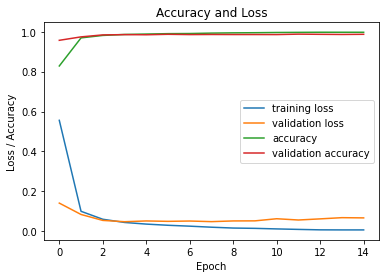

In [ ]:
fig = plt.figure()
plt.plot(np.arange(0, num_epochs), training.history['loss'], label='training loss')
plt.plot(np.arange(0, num_epochs), training.history['val_loss'], label='validation loss')
plt.plot(np.arange(0, num_epochs), training.history['accuracy'], label='accuracy')
plt.plot(np.arange(0, num_epochs), training.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
#Có thể thấy là mô hình cho ra kết quả trên tập train với tập validation vượt trội hơn mô hình cũ -> Hàm loss của tập training vẫn giảm mà không có dấu hiệu nhảy qua nhảy lại giữa điểm tối ưu sớm như mô hình cũ.

In [ ]:
Y_test = mnist.load_data()[1][1]
Y_test = np_utils.to_categorical(Y_test)
X_positions = np.full((X_test.shape[0], 64, after_conv), np.linspace(1, after_conv, after_conv))
print(X_test.shape)
model_attention.evaluate([X_test, X_positions.reshape(X_test.shape[0], -1)], Y_test)
#Kết quả trên tập test cũng vượt trội hơn mô hình cũ

(10000, 28, 28, 1)
313/313 [==============================] - 21s 67ms/step - loss: 0.0549 - accuracy: 0.9882


[0.05488114804029465, 0.9882000088691711]